<a href="https://colab.research.google.com/github/AnovaYoung/linear-regression-for-IoT/blob/main/Linear_Regression_for_IoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [ ]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [ ]:
#Load your data into a pandas dataframe here
df = pd.read_csv('/Users/anovayoungers/Downloads/df_cleaned_EC.csv')

In [ ]:
print(df.head())

   Global_active_power  Global_reactive_power   Voltage  Global_intensity  \
0              4.21600                0.41800 234.84000          18.40000   
1              5.36000                0.43600 233.63000          23.00000   
2              5.37400                0.49800 233.29000          23.00000   
3              5.38800                0.50200 233.74000          23.00000   
4              3.66600                0.52800 235.68000          15.80000   

   Sub_metering_1  Sub_metering_2  Sub_metering_3        Date      Time  
0         0.00000         1.00000        17.00000  2006-12-16  17:24:00  
1         0.00000         1.00000        16.00000  2006-12-16  17:25:00  
2         0.00000         2.00000        17.00000  2006-12-16  17:26:00  
3         0.00000         1.00000        17.00000  2006-12-16  17:27:00  
4         0.00000         1.00000        17.00000  2006-12-16  17:28:00  


In [ ]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert 'Datetime' to Unix time
df['unix'] = df['Datetime'].astype('int64') // 10**9


## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: ph is the time frame I'm predicting into the future. mu represents a learning rate or a momentum term, which controls how much the model parameters are updated during training.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [ ]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5
ph_index = ph
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: 1.8126113170475857e-229

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [ ]:
mu = 0.9
n = 5000
first_data_point_weight = mu ** (n - 1)
print(first_data_point_weight)

1.8126113170475857e-229


In [ ]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] =  mu ** (ns - k - 1)
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i - 1+ ph_index]
    yp = m_tmp * tp + q_tmp

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

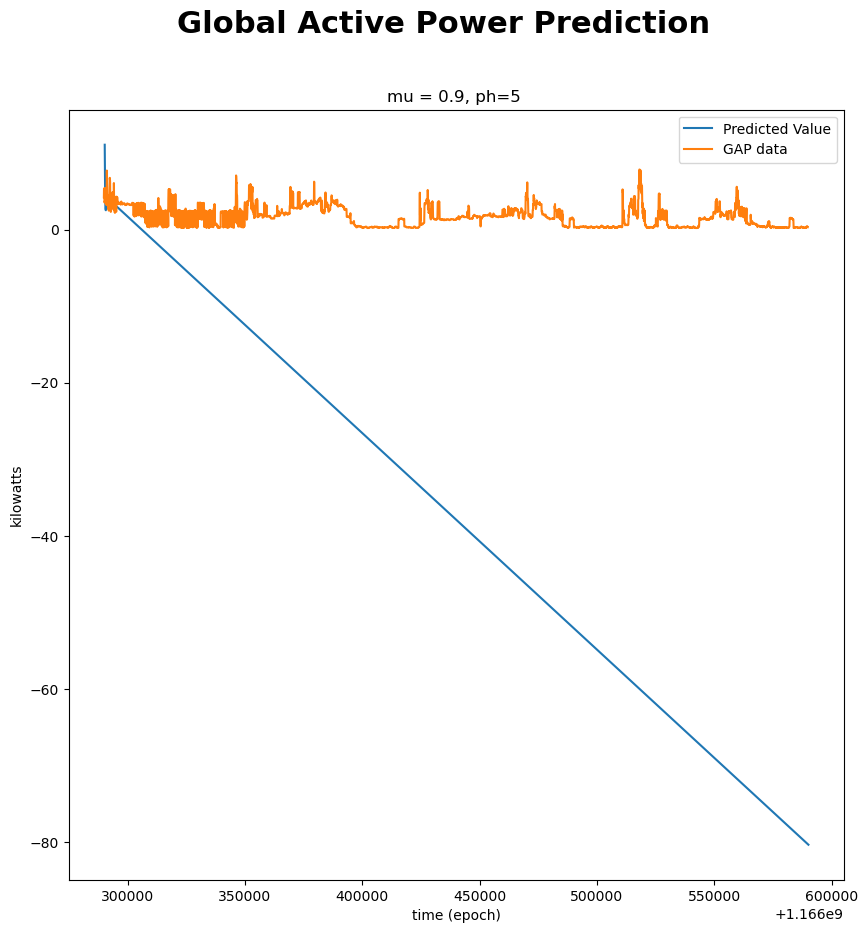

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value')
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

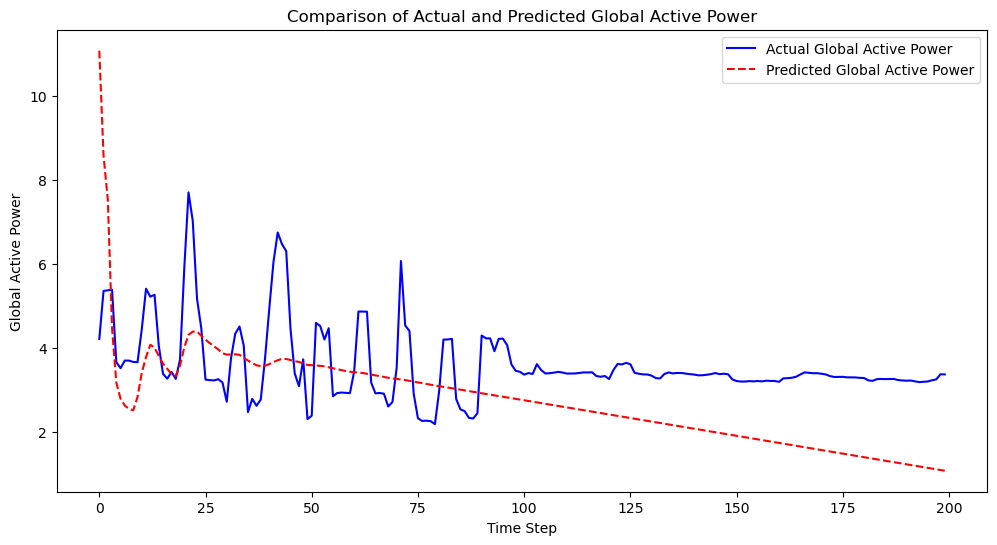

In [ ]:
#Plot first 200 data points/predictions
import matplotlib.pyplot as plt

ys_plot = ys.iloc[:200]
yp_pred_plot = yp_pred[:200]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(ys_plot, label='Actual Global Active Power', color='blue')
plt.plot(yp_pred_plot, label='Predicted Global Active Power', color='red', linestyle='dashed')

plt.title('Comparison of Actual and Predicted Global Active Power')
plt.xlabel('Time Step')
plt.ylabel('Global Active Power')
plt.legend()

plt.show()


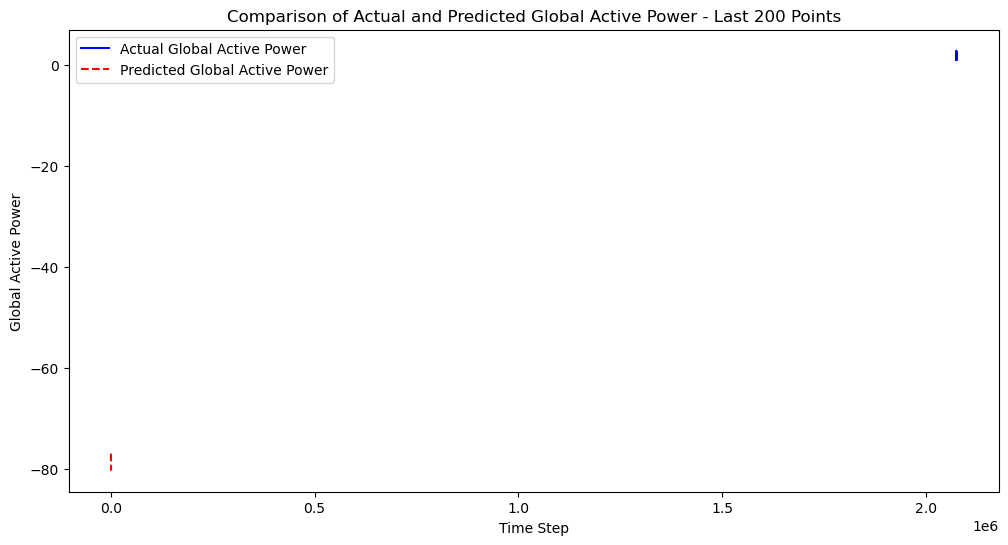

In [ ]:
#Plot last 200 data points/predictions

ys_plot = ys.iloc[-200:]
yp_pred_plot = yp_pred[-200:]

plt.figure(figsize=(12, 6))
plt.plot(ys_plot, label='Actual Global Active Power', color='blue')
plt.plot(yp_pred_plot, label='Predicted Global Active Power', color='red', linestyle='dashed')

plt.title('Comparison of Actual and Predicted Global Active Power - Last 200 Points')
plt.xlabel('Time Step')
plt.ylabel('Global Active Power')
plt.legend()

plt.show()

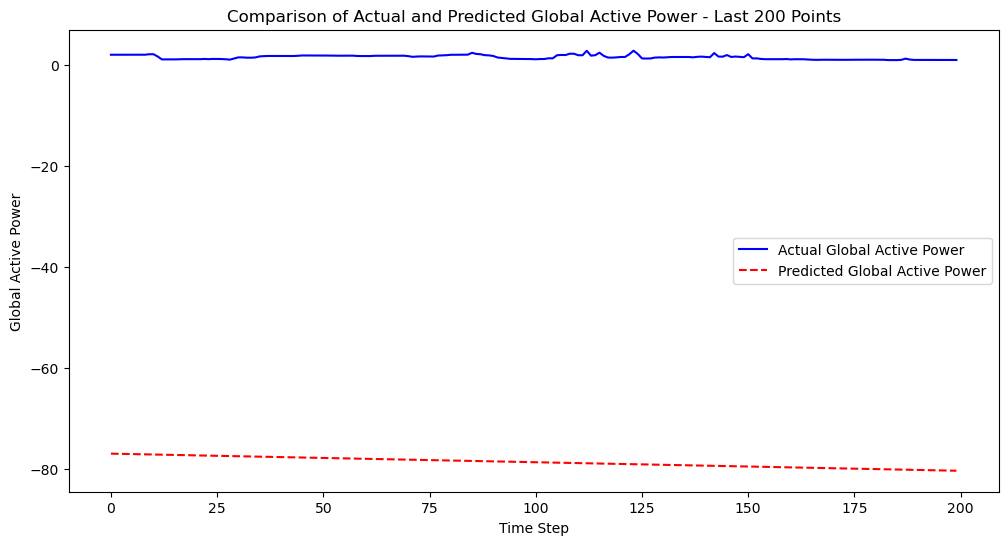

In [ ]:
ys_plot = ys.iloc[-200:].reset_index(drop=True)
yp_pred_plot = yp_pred[-200:]

x_axis = range(len(ys_plot))

plt.figure(figsize=(12, 6))
plt.plot(x_axis, ys_plot, label='Actual Global Active Power', color='blue')
plt.plot(x_axis, yp_pred_plot, label='Predicted Global Active Power', color='red', linestyle='dashed')

plt.title('Comparison of Actual and Predicted Global Active Power - Last 200 Points')
plt.xlabel('Time Step')
plt.ylabel('Global Active Power')
plt.legend()

plt.show()

In [ ]:
#Calculate MSE of predictions
from sklearn.metrics import mean_squared_error

# Arrays to hold predicted values
tp_pred = np.zeros(n_s - ph_index)
yp_pred = np.zeros(n_s - ph_index)

# Calculate the MSE
mse_value = mean_squared_error(ys['Global_active_power'][ph_index:n_s], yp_pred)


print("MSE is", mse_value)


MSE is 4.6274354922922925


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model seems to have some predictive power, especially in the earlier stages of the dataset, but it struggles with the variability towards the end of the dataset.
The high MSE value, influenced by the poor predictions towards the end of the time series, suggests that the model's assumptions may not hold throughout the entire dataset or that there were other factors influencing the GAP that were not included in the model.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

MSE with mu=1: 1.4443580872898596


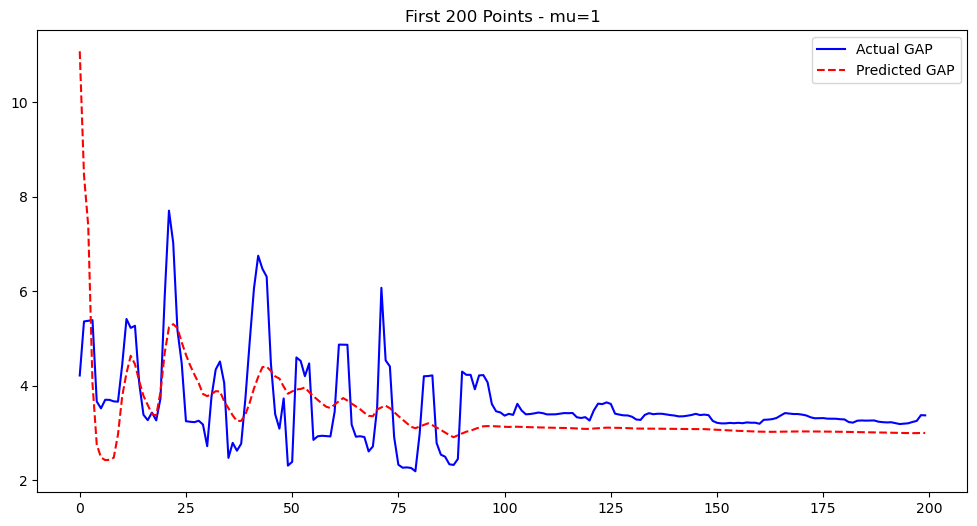

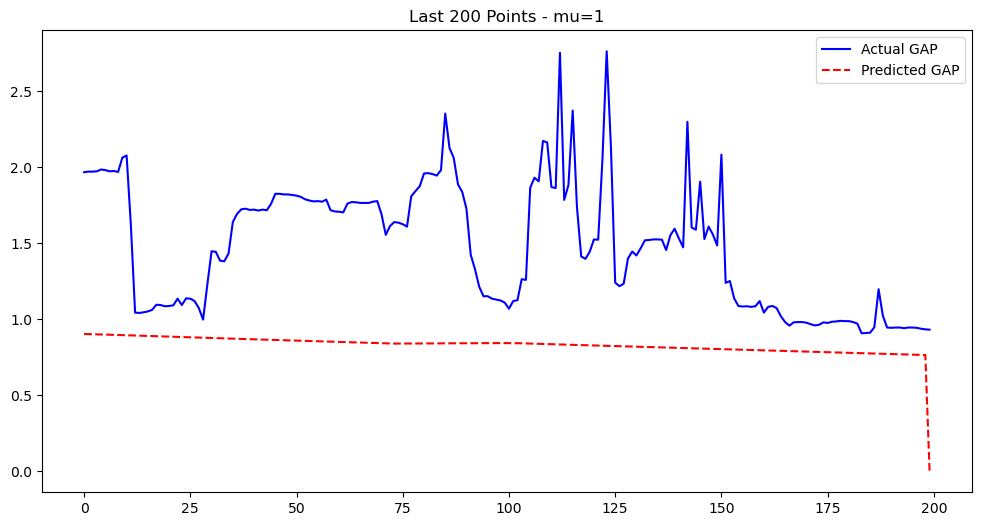

MSE with mu=0.01: 7.991668050131817


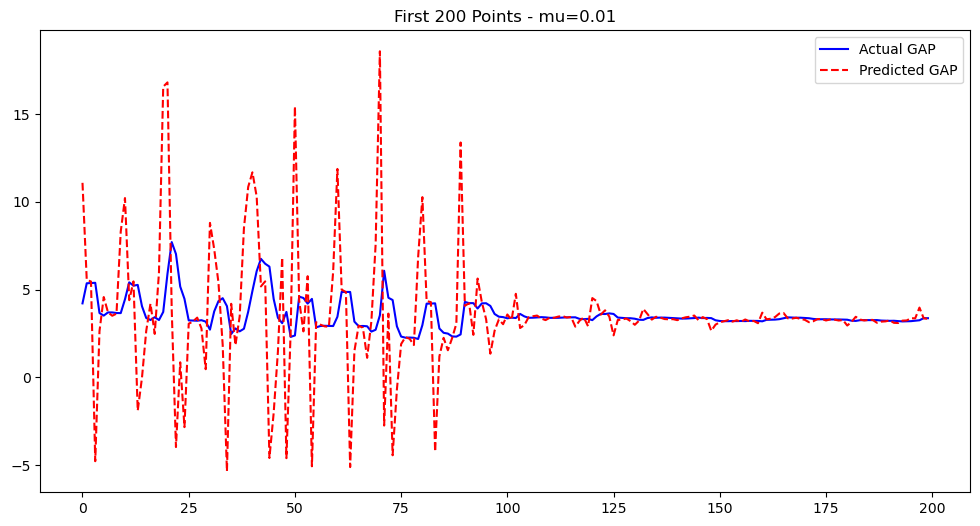

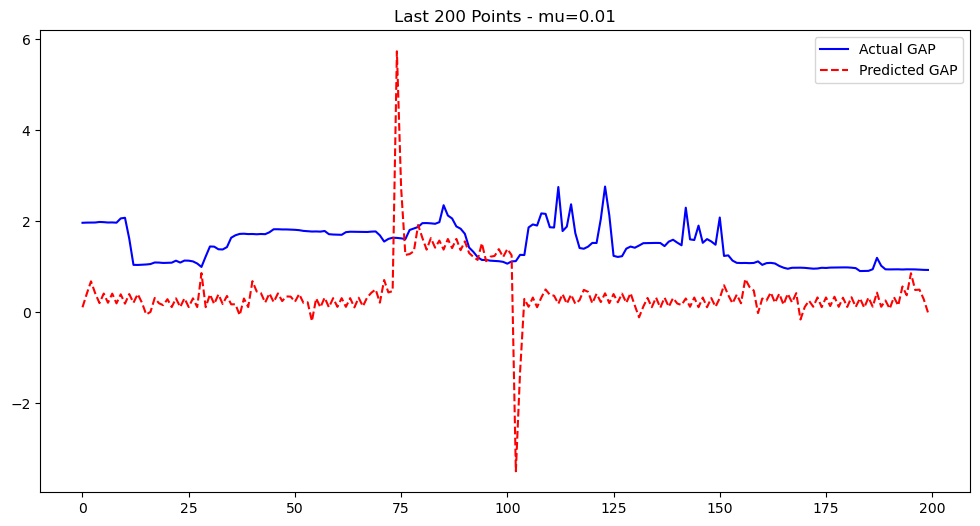

In [ ]:
# Setup
n_s = 5000
mu_values = [1, 0.01]

ts = pd.DataFrame(df['unix'])
ys = pd.DataFrame(df['Global_active_power'])

# Loop over the different mu values
for mu in mu_values:
    # Arrays to hold predicted values - Again
    tp_pred = np.zeros(n_s - ph_index)
    yp_pred = np.zeros(n_s - ph_index)

    # Prediction loop
    for i in range(2, n_s+1):
        # Get x and y data "available" for prediction
        ts_tmp = ts.iloc[:i]
        ys_tmp = ys.iloc[:i]
        ns = len(ys_tmp)

        # Adjust weights according to the current mu
        weights = np.array([mu ** (ns - 1 - j) for j in range(ns)])

        # Perform linear regression on "available" data using adjusted weights
        lm_tmp = LinearRegression()
        model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

        # Store model coefficients and intercepts
        m_tmp = model_tmp.coef_[0]
        q_tmp = model_tmp.intercept_

        # Use ph_index to make the model prediction according to the prediction time
        if i + ph_index <= n_s:
            tp = ts.iloc[i + ph_index - 1]
            yp = m_tmp * tp + q_tmp
            tp_pred[i-2] = tp
            yp_pred[i-2] = yp

    # MSE for the current set of predictions
    mse_value = mean_squared_error(ys['Global_active_power'][ph_index:n_s], yp_pred)
    print(f"MSE with mu={mu}:", mse_value)

    # Plot first 200 data points/predictions
    plt.figure(figsize=(12, 6))
    plt.plot(ys.iloc[:200].reset_index(drop=True), label='Actual GAP', color='blue')
    plt.plot(yp_pred[:200], label='Predicted GAP', color='red', linestyle='dashed')
    plt.title(f'First 200 Points - mu={mu}')
    plt.legend()
    plt.show()

    # Plot last 200 data points/predictions
    plt.figure(figsize=(12, 6))
    plt.plot(ys.iloc[-200:].reset_index(drop=True), label='Actual GAP', color='blue')
    plt.plot(yp_pred[-200:], label='Predicted GAP', color='red', linestyle='dashed')
    plt.title(f'Last 200 Points - mu={mu}')
    plt.legend()
    plt.show()


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The charts for mu = 1 show that the predicted Global Active Power generally follows the actual data's trend. In the early predictions, the model seems to capture the trend but not the fine details of the fluctuations. In the late predictions, the model still follows the trend but appears to be smoother and slightly underestimating the actual values.
The MSE for mu = 1 is relatively low (1.444), suggesting that the model predictions are close to the actual data on average.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: the early predictions chart shows that the predicted values are more erratic, with some predictions going into negative values, which might not make sense for the actual physical quantity being measured.
The late predictions chart for mu = 0.01 shows a model that does not capture the actual data's trends or fluctuations well.
The MSE for mu = 0.01 is higher (7.992), indicating that on average, the predictions are further from the actual data points compared to the mu = 1 model.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: Comparing the MSE values and the charts, the mu = 1 model performs the best among the three models (including the previous mu value which had an MSE of 4.627). The lower MSE indicates better average performance in terms of prediction error.
The mu parameter represents the weight given to the more recent data points in the weighted linear regression. A mu of 1 essentially gives equal weight to all data points, which in this case provides a good balance between capturing the trend and not overfitting to fluctuations.
The mu = 0.01 model, with a very low mu, heavily discounts the influence of older data points, leading to erratic predictions that are heavily influenced by the most recent data points, this results in a poor fit.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: Experiment with different values of mu or other hyperparameters if continuing on to more complex models.
Perform cross-validation to ensure that the model generalizes well to unseen data.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [ ]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame({
    'unix': df['unix'],
    'Voltage': df['Voltage']
})

ys = pd.DataFrame(df.Global_active_power)

ph = 5
ph_index = 5
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [ ]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage

# Prediction loop
for i in range(2, n_s+1):

    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]

    # linear regression on "available" data
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp)

    # Store model coefficients and intercepts to compute prediction
    # Now I have two coefficients: one for time and one for voltage
    m_time_tmp = model_tmp.coef_[0][0]  # Coefficient for time
    m_voltage_tmp = model_tmp.coef_[0][1]  # Coefficient for voltage
    q_tmp = model_tmp.intercept_

    # Use ph_index to make the model prediction according to the prediction time

    if i + ph_index <= n_s:
        tp = ts.iloc[i + ph_index - 1]
        # Prediction now includes both coefficients
        yp = m_time_tmp * tp['unix'] + m_voltage_tmp * tp['Voltage'] + q_tmp
        tp_pred[i - 2] = tp['unix']
        yp_pred[i - 2] = yp


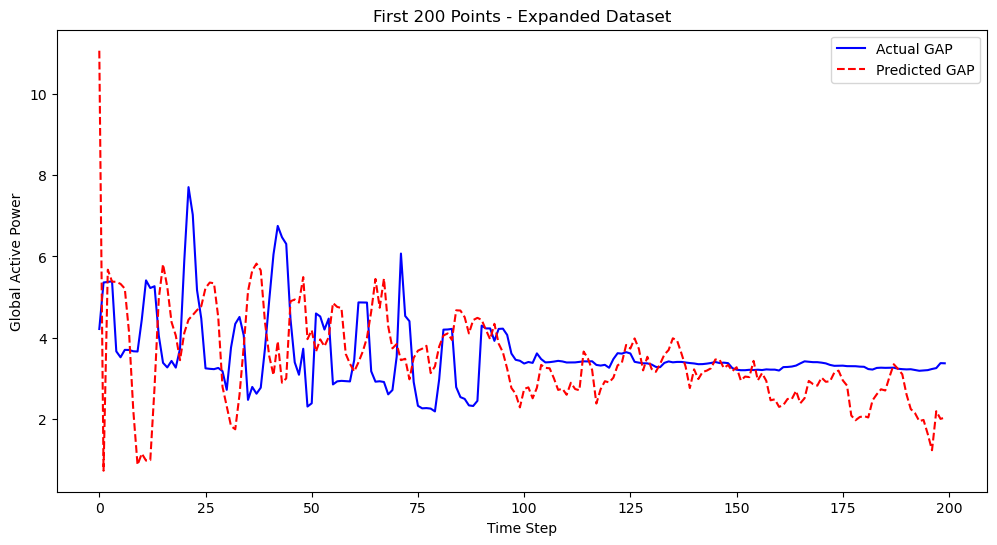

In [ ]:
#Plot first 200 data points/predictions for the expanded dataset


# Convert predictions to a DataFrame for easier handling
yp_pred_df = pd.DataFrame(yp_pred, columns=['Predicted_GAP'])

# Plot first 200 data points
plt.figure(figsize=(12, 6))
plt.plot(ys.iloc[:200].reset_index(drop=True), label='Actual GAP', color='blue')
plt.plot(yp_pred_df.iloc[:200], label='Predicted GAP', color='red', linestyle='dashed')
plt.title('First 200 Points - Expanded Dataset')
plt.xlabel('Time Step')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()




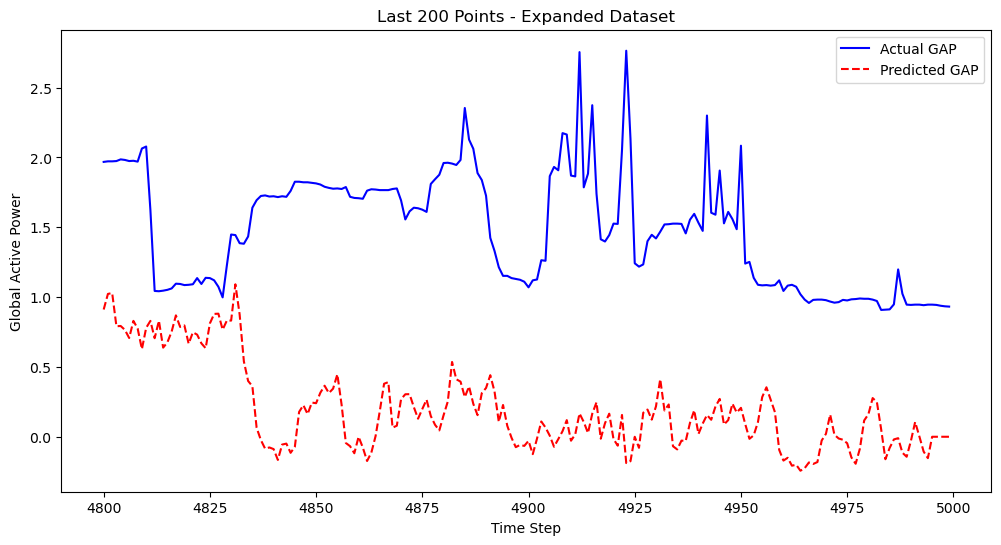

In [ ]:
#  `yp_pred_df` contains the predicted values

# Plot last 200 data points/predictions
plt.figure(figsize=(12, 6))
plt.plot(range(n_s-200, n_s), ys.iloc[-200:], label='Actual GAP', color='blue')
plt.plot(range(n_s-200, n_s), yp_pred_df.iloc[-200:], label='Predicted GAP', color='red', linestyle='dashed')
plt.title('Last 200 Points - Expanded Dataset')
plt.xlabel('Time Step')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


In [ ]:
#Calculate MSE of predictions for the expanded data
n_s_corrected = len(yp_pred_df)

actual_values = ys['Global_active_power'][ph_index:n_s_corrected + ph_index]

# Make sure the lengths match before calculating MSE
if len(actual_values) == len(yp_pred_df):
    mse_expanded = mean_squared_error(actual_values, yp_pred_df)
    print("MSE for the expanded dataset:", mse_expanded)
else:
    print("Cannot calculate MSE, array lengths do not match.")
    print(f"Length of actual values: {len(actual_values)}, Length of predictions: {len(yp_pred_df)}")


MSE for the expanded dataset: 0.7782043582167981


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: The MSE for the expanded dataset with voltage data is 0.7782, which is significantly lower than the previous models. The lower MSE indicates that the predictions from the model with voltage data are closer to the actual values, on average, compared to the models without it

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: One alternative approach to improving the model could be to use a moving average as the response variable. This method would involve smoothing out the short-term fluctuations in the Global Active Power and predicting the moving average instead. The rationale behind this is that it might be easier to predict the smoothed trend of the power usage rather than the individual values, which can be subject to more noise and sudden changes.

In [ ]:
#create your alternative training data here

# Calculate the moving average for the Global_active_power
window_size = ph
ys_moving_avg = df['Global_active_power'].rolling(window=window_size).mean()

# Drop the NaN values from the moving average calculation
ys_moving_avg = ys_moving_avg.dropna()

# The time series data 'ts' will need to be adjusted to match the length of 'ys_moving_avg'
ts_adjusted = df.iloc[window_size - 1:, :].copy()  # Adjusting start to align with the moving average
ts_adjusted['unix'] = pd.to_datetime(ts_adjusted['Date'] + ' ' + ts_adjusted['Time']).astype('int64') // 10**9

# Now I'm creating the feature matrix 'ts' including only 'unix' as before
ts = pd.DataFrame(ts_adjusted['unix'])

# Set the prediction horizon
ph = 5  # 5 minutes
ph_index = 5

mu = 0.9

n_s = min(len(ys_moving_avg), 5000)

# Initialize arrays for predicted values
tp_pred = np.zeros(n_s - ph_index)
yp_pred = np.zeros(n_s - ph_index)



In [ ]:
#re-run the prediction code here


for i in range(ph_index, n_s):
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i - window_size + 1]
    ys_tmp = ys_moving_avg.iloc[:i - window_size + 1]

    # Perform linear regression on "available" data
    if len(ts_tmp) > 0 and len(ys_tmp) > 0:
        lm_tmp = LinearRegression()
        model_tmp = lm_tmp.fit(ts_tmp, ys_tmp)

        # Predict using the model
        tp = ts.iloc[i - 1].values.reshape(1, -1)
        yp = model_tmp.predict(tp)[0]

        # Store the predictions
        tp_pred[i - ph_index] = ts.iloc[i - 1]
        yp_pred[i - ph_index] = yp



/Users/anovayoungers/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/anovayoungers/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/anovayoungers/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/anovayoungers/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/anovayoungers/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/User

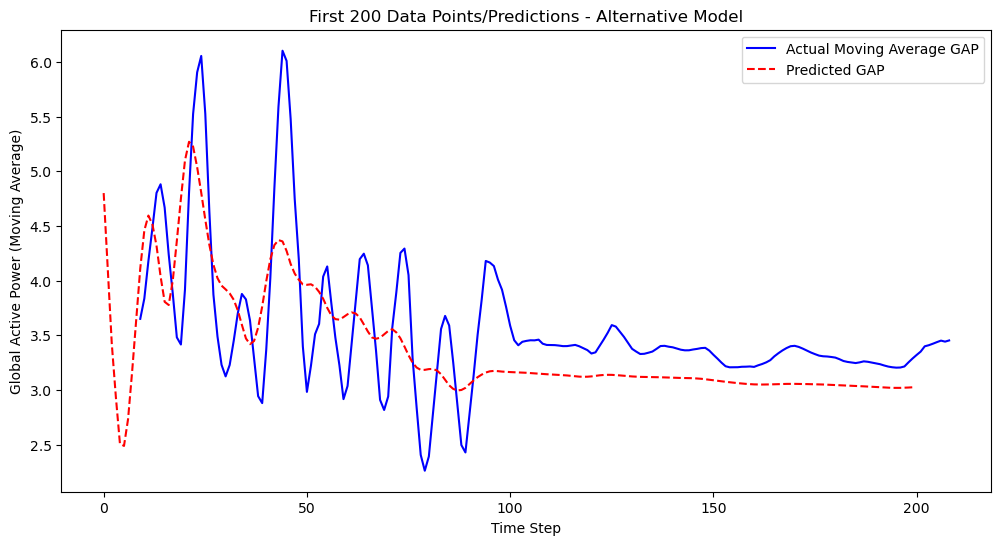

In [ ]:
#Plot first 200 data points/predictions for alternative model

plt.figure(figsize=(12, 6))
plt.plot(ys_moving_avg.iloc[ph_index:ph_index+200], label='Actual Moving Average GAP', color='blue')
plt.plot(yp_pred[:200], label='Predicted GAP', color='red', linestyle='dashed')
plt.title('First 200 Data Points/Predictions - Alternative Model')
plt.xlabel('Time Step')
plt.ylabel('Global Active Power (Moving Average)')
plt.legend()
plt.show()


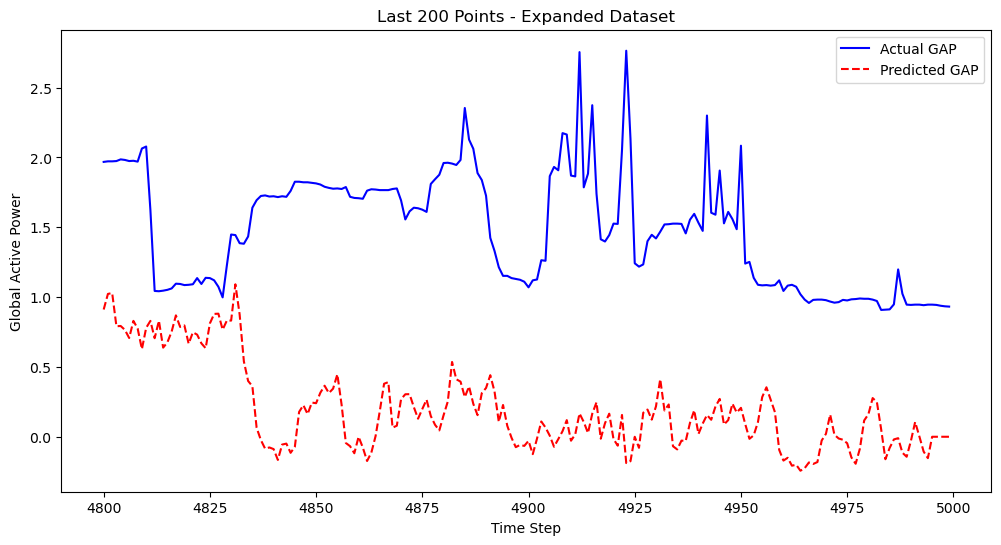

In [ ]:

# Plot last 200 data points/predictions
plt.figure(figsize=(12, 6))
plt.plot(range(n_s-200, n_s), ys.iloc[-200:], label='Actual GAP', color='blue')
plt.plot(range(n_s-200, n_s), yp_pred_df.iloc[-200:], label='Predicted GAP', color='red', linestyle='dashed')
plt.title('Last 200 Points - Expanded Dataset')
plt.xlabel('Time Step')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


In [ ]:
#Calculate MSE of predictions for alternative model

mse_alternative = mean_squared_error(ys_moving_avg.iloc[ph_index:n_s], yp_pred)
print("MSE for the alternative model:", mse_alternative)


MSE for the alternative model: 1.2557995165809914


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: The Mean Squared Error for the alternative model using the moving average as the response variable is 1.2557995165809914, which is between the MSE for the model with mu=1 (which was 1.4443580872898596) and the original model (which was 4.6274354922922925). This suggests that while the moving average model has not outperformed all previous models, it has improved upon the original.

When assessing whether the model improved, I should compare it against the MSE for the expanded dataset that included voltage data, which was 0.7782043582167981. In this case, my moving average model did not perform as well, since its MSE is higher, indicating less accuracy.

To improve the model while still using linear regression I can create new features that may have predictive power, such as time of day, day of the week, or interaction terms between existing features. I could introduce polynomial or interaction terms to capture non-linear relationships in the data. Also I can apply regularization techniques like Ridge or Lasso to prevent overfitting and help the model generalize better to unseen data.

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.